# ***1. data preperation***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown https://drive.google.com/uc?id=19Ijik5kYO3jlpN7wn9i4sgt45QK8L5Ne

Downloading...
From (original): https://drive.google.com/uc?id=19Ijik5kYO3jlpN7wn9i4sgt45QK8L5Ne
From (redirected): https://drive.google.com/uc?id=19Ijik5kYO3jlpN7wn9i4sgt45QK8L5Ne&confirm=t&uuid=4b1dc1cb-27c6-422e-af45-16fbda0e8e7d
To: /content/D4_Cataract.zip
100% 988M/988M [00:06<00:00, 143MB/s]


In [ ]:
!unzip -qq /content/D4_Cataract.zip

# ***2. data preprocessing***

In [ ]:
# 필요한 패키지를 설치
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 33.8 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import ImageFile
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
from torch.utils.data import DataLoader, SubsetRandomSampler
from transformers import ViTForImageClassification, ViTConfig
import os
from torch.utils.data import DataLoader, random_split
import timm

In [ ]:
# gpu 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

# 예시로 seed를 42로 설정
set_seed(42)

In [ ]:
# 데이터 경로 설정
data_path = "/content/D4_Cataract"

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),           # 이미지 크기 조절
    transforms.RandomHorizontalFlip(),       # 무작위로 좌우 뒤집기
    transforms.RandomVerticalFlip(),         # 무작위로 상하 뒤집기
    transforms.RandomRotation(degrees=30),   # 무작위로 회전
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),  # 무작위 변환
    transforms.RandomResizedCrop(224),       # 임의 크기로 자르고 크기 조정
    transforms.ToTensor(),                   # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 이미지를 정규화
])

dataset = datasets.ImageFolder(root=data_path, transform=transform)

# 비율 설정
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# 데이터셋을 8:1:1 비율로 훈련, 검증, 테스트 세트로 분할
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# 데이터 로더 설정
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 클래스 라벨 가져오기
class_labels = dataset.classes

# 클래스 라벨 출력
print("클래스 라벨:", class_labels)


클래스 라벨: ['Early-stage', 'Immature', 'Mature', 'negative']


## ***2-1. image visualization***

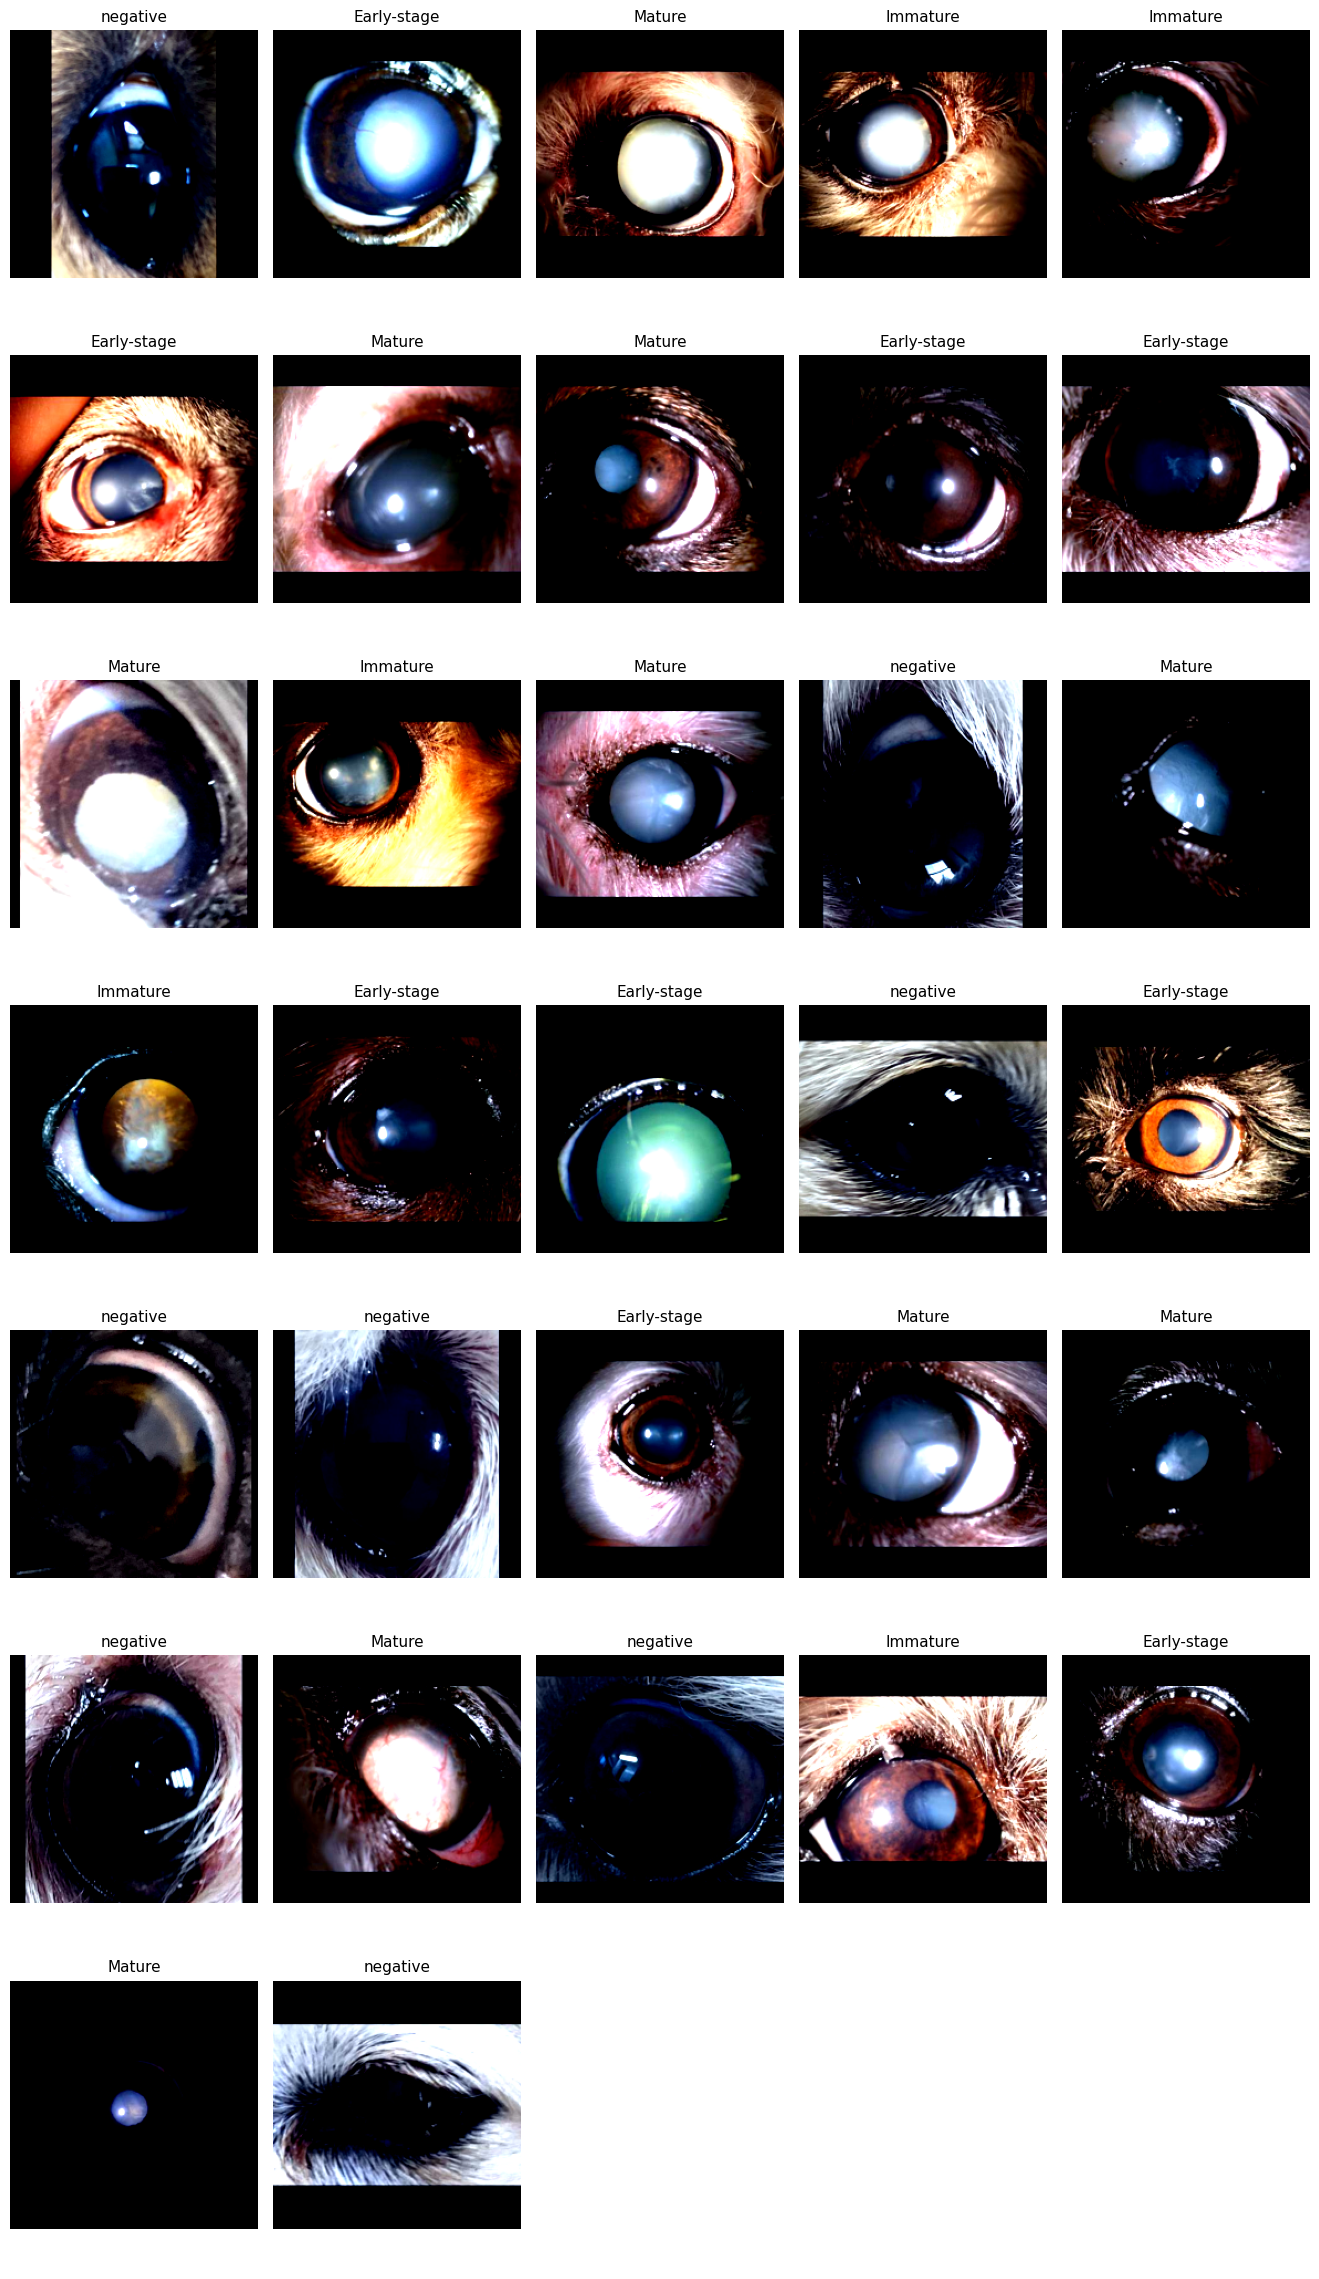

In [ ]:
# 데이터로더에서 이미지와 레이블 가져오기
images, labels = next(iter(train_loader))

# 클래스 인덱스와 클래스명 매핑
class_names = dataset.classes

# 이미지 확인을 위한 코드
num_images = len(images)
num_columns = 5  # 한 줄에 표시할 이미지 수

num_rows = (num_images + num_columns - 1) // num_columns  # 필요한 행 수 계산
fig, axs = plt.subplots(num_rows, num_columns, figsize=(13.3, 3.3 * num_rows))  # 플롯의 크기 조정

for i in range(num_images):
    row = i // num_columns  # 현재 이미지의 행
    col = i % num_columns  # 현재 이미지의 열

    image = images[i].permute(1, 2, 0)  # 이미지의 차원을 (H, W, C)로 변경
    image = 0.5 * image + 0.5  # 이미지를 정규화 해제

    axs[row, col].imshow(image)
    axs[row, col].set_title(class_names[labels[i].item()], fontsize=11)  # 클래스명 표시, 폰트 크기 조정 (1포인트 증가)
    axs[row, col].axis('off')

# 남은 공간에 빈 플롯 생성
for i in range(num_images, num_rows * num_columns):
    row = i // num_columns  # 현재 이미지의 행
    col = i % num_columns  # 현재 이미지의 열
    axs[row, col].axis('off')

plt.tight_layout()  # 레이아웃 조정
plt.show()

# ***3. model load & parameter***

In [ ]:
# timm 라이브러리를 사용하여 ViT 모델 불러오기
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# 드롭아웃 확률 설정
dropout_prob = 0.2

# 기존 분류 레이어의 입력 특성 수 가져오기
in_features = model.head.in_features

# 새로운 분류 레이어 정의
num_classes = 4  # 새로운 클래스 수
classifier = nn.Sequential(
    nn.Dropout(dropout_prob),
    nn.Linear(in_features, num_classes)
)

# 모델의 분류 레이어를 새로운 분류기로 교체
model.head = classifier

# GPU를 사용할 수 있다면 모델을 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 새로운 분류 레이어가 올바르게 설정되었는지 확인
print(model.head)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=768, out_features=4, bias=True)
)


In [ ]:
# 모델 출력
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

# ***4. criterion & optimizer***

In [ ]:
# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr=1.4652689660935326e-05, weight_decay=0.0037994053452793768)

from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

# ***5. model training***

In [ ]:
# 배치 수 확인
total_batch = len(train_loader)
print(total_batch) # 5504*3/32

689


In [ ]:
import time
from tqdm import tqdm
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn.functional as F

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, patience=5, num_epochs=50, device='cuda'):
    model.to(device)

    results = {
        'epoch_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'train_loss': [],
        'train_accuracy': []
    }

    best_val_loss = float('inf')
    no_improvement_count = 0

    try:
        for epoch in range(num_epochs):
            epoch_start_time = time.time()

            # Training
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader.dataset)
            train_accuracy = correct / total
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

            # Validation
            if val_loader is not None:
                model.eval()
                val_loss = 0.0
                correct = 0
                total = 0
                predictions = []
                targets = []
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        _, predicted = torch.max(outputs, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                        val_loss += criterion(outputs, labels).item() * inputs.size(0)
                        predictions.extend(predicted.cpu().numpy())
                        targets.extend(labels.cpu().numpy())

                val_accuracy = correct / total
                val_loss = val_loss / len(val_loader.dataset)

                val_precision = precision_score(targets, predictions, average='weighted')
                val_recall = recall_score(targets, predictions, average='weighted')
                val_f1 = f1_score(targets, predictions, average='weighted')

                print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation F1 Score: {val_f1:.4f}, Time: {time.time() - epoch_start_time:.0f}s")

                results['epoch_loss'].append(train_loss)
                results['val_loss'].append(val_loss)
                results['val_accuracy'].append(val_accuracy)
                results['val_precision'].append(val_precision)
                results['val_recall'].append(val_recall)
                results['val_f1'].append(val_f1)
                results['train_loss'].append(train_loss)
                results['train_accuracy'].append(train_accuracy)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1

                if no_improvement_count >= patience:
                    print(f"No improvement in validation loss for {patience} epochs. Early stopping...")
                    break
            else:
                print("No validation data available. Skipping validation...")

    except Exception as e:
        print(f"An error occurred during training: {str(e)}")

    if results['val_accuracy']:
        best_epoch = np.argmax(results['val_accuracy'])
        best_accuracy = results['val_accuracy'][best_epoch]
        print(f"Best Validation Accuracy: {best_accuracy:.4f} at Epoch {best_epoch+1}")
    else:
        best_epoch = None
        best_accuracy = None
        print("No validation data available.")

    best_model = model
    torch.save(best_model.state_dict(), 'best_model.pth')

    return results, best_model


In [ ]:
# 모델 학습
results, best_model = train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)

Epoch 1/50: 100%|██████████| 689/689 [06:56<00:00,  1.65it/s]


Epoch 1/50, Train Loss: 0.6657, Train Accuracy: 0.6984
Epoch 1/50, Validation Loss: 0.5541, Validation Accuracy: 0.7627, Validation Precision: 0.7641, Validation Recall: 0.7627, Validation F1 Score: 0.7631, Time: 443s


Epoch 2/50: 100%|██████████| 689/689 [06:56<00:00,  1.65it/s]


Epoch 2/50, Train Loss: 0.5407, Train Accuracy: 0.7612
Epoch 2/50, Validation Loss: 0.5308, Validation Accuracy: 0.7613, Validation Precision: 0.7606, Validation Recall: 0.7613, Validation F1 Score: 0.7533, Time: 443s


Epoch 3/50: 100%|██████████| 689/689 [06:57<00:00,  1.65it/s]


Epoch 3/50, Train Loss: 0.5036, Train Accuracy: 0.7798
Epoch 3/50, Validation Loss: 0.4741, Validation Accuracy: 0.7911, Validation Precision: 0.7896, Validation Recall: 0.7911, Validation F1 Score: 0.7899, Time: 444s


Epoch 4/50: 100%|██████████| 689/689 [06:57<00:00,  1.65it/s]


Epoch 4/50, Train Loss: 0.4739, Train Accuracy: 0.7937
Epoch 4/50, Validation Loss: 0.5100, Validation Accuracy: 0.7758, Validation Precision: 0.7937, Validation Recall: 0.7758, Validation F1 Score: 0.7773, Time: 444s


Epoch 5/50: 100%|██████████| 689/689 [06:58<00:00,  1.65it/s]


Epoch 5/50, Train Loss: 0.4588, Train Accuracy: 0.8020
Epoch 5/50, Validation Loss: 0.5019, Validation Accuracy: 0.7776, Validation Precision: 0.8102, Validation Recall: 0.7776, Validation F1 Score: 0.7817, Time: 445s


Epoch 6/50: 100%|██████████| 689/689 [06:56<00:00,  1.65it/s]


Epoch 6/50, Train Loss: 0.4473, Train Accuracy: 0.8066
Epoch 6/50, Validation Loss: 0.4753, Validation Accuracy: 0.7954, Validation Precision: 0.8272, Validation Recall: 0.7954, Validation F1 Score: 0.7988, Time: 443s


Epoch 7/50: 100%|██████████| 689/689 [06:56<00:00,  1.65it/s]


Epoch 7/50, Train Loss: 0.4427, Train Accuracy: 0.8092
Epoch 7/50, Validation Loss: 0.4795, Validation Accuracy: 0.7987, Validation Precision: 0.8119, Validation Recall: 0.7987, Validation F1 Score: 0.8010, Time: 443s


Epoch 8/50: 100%|██████████| 689/689 [06:58<00:00,  1.65it/s]


Epoch 8/50, Train Loss: 0.4322, Train Accuracy: 0.8123
Epoch 8/50, Validation Loss: 0.4420, Validation Accuracy: 0.8063, Validation Precision: 0.8064, Validation Recall: 0.8063, Validation F1 Score: 0.8057, Time: 445s


Epoch 9/50: 100%|██████████| 689/689 [06:57<00:00,  1.65it/s]


Epoch 9/50, Train Loss: 0.4241, Train Accuracy: 0.8184
Epoch 9/50, Validation Loss: 0.4745, Validation Accuracy: 0.8012, Validation Precision: 0.7989, Validation Recall: 0.8012, Validation F1 Score: 0.7983, Time: 444s


Epoch 10/50: 100%|██████████| 689/689 [06:57<00:00,  1.65it/s]


Epoch 10/50, Train Loss: 0.4146, Train Accuracy: 0.8253
Epoch 10/50, Validation Loss: 0.4523, Validation Accuracy: 0.8107, Validation Precision: 0.8243, Validation Recall: 0.8107, Validation F1 Score: 0.8127, Time: 445s


Epoch 11/50: 100%|██████████| 689/689 [06:57<00:00,  1.65it/s]


Epoch 11/50, Train Loss: 0.4082, Train Accuracy: 0.8258
Epoch 11/50, Validation Loss: 0.4657, Validation Accuracy: 0.8020, Validation Precision: 0.8093, Validation Recall: 0.8020, Validation F1 Score: 0.8027, Time: 443s


Epoch 12/50: 100%|██████████| 689/689 [06:57<00:00,  1.65it/s]


Epoch 12/50, Train Loss: 0.4060, Train Accuracy: 0.8258
Epoch 12/50, Validation Loss: 0.4783, Validation Accuracy: 0.8005, Validation Precision: 0.7994, Validation Recall: 0.8005, Validation F1 Score: 0.7956, Time: 443s


Epoch 13/50: 100%|██████████| 689/689 [06:56<00:00,  1.65it/s]


Epoch 13/50, Train Loss: 0.4083, Train Accuracy: 0.8258
Epoch 13/50, Validation Loss: 0.4482, Validation Accuracy: 0.8114, Validation Precision: 0.8157, Validation Recall: 0.8114, Validation F1 Score: 0.8105, Time: 443s
No improvement in validation loss for 5 epochs. Early stopping...
Best Validation Accuracy: 0.8114 at Epoch 13


In [ ]:
# 모델 자체를 저장

PATH = '/content/drive/MyDrive/D4_VIT.pth'
torch.save(model, PATH) # 해당 path에 모델을 저장

In [ ]:
import pandas as pd

# 훈련 결과를 DataFrame으로 변환
results_df = pd.DataFrame({
    'Epoch': range(1, len(results['epoch_loss']) + 1),
    'Train Loss': results['train_loss'],
    'Train Accuracy': results['train_accuracy'],
    'Validation Loss': results['val_loss'],
    'Validation Accuracy': results['val_accuracy'],
    'Validation Precision': results['val_precision'],
    'Validation Recall': results['val_recall'],
    'Validation F1 Score': results['val_f1']
})

# DataFrame 출력
print(results_df)

    Epoch  Train Loss  Train Accuracy  Validation Loss  Validation Accuracy  \
0       1    0.665735        0.698379         0.554093             0.762718   
1       2    0.540742        0.761183         0.530770             0.761265   
2       3    0.503551        0.779801         0.474120             0.791061   
3       4    0.473889        0.793652         0.510034             0.775799   
4       5    0.458783        0.802007         0.501853             0.777616   
5       6    0.447338        0.806594         0.475298             0.795422   
6       7    0.442698        0.809228         0.479461             0.798692   
7       8    0.432175        0.812270         0.442009             0.806323   
8       9    0.424094        0.818446         0.474490             0.801235   
9      10    0.414613        0.825258         0.452341             0.810683   
10     11    0.408246        0.825848         0.465712             0.801962   
11     12    0.405979        0.825803         0.4783

# ***6. model save***

## ***5-2. loss visualization***

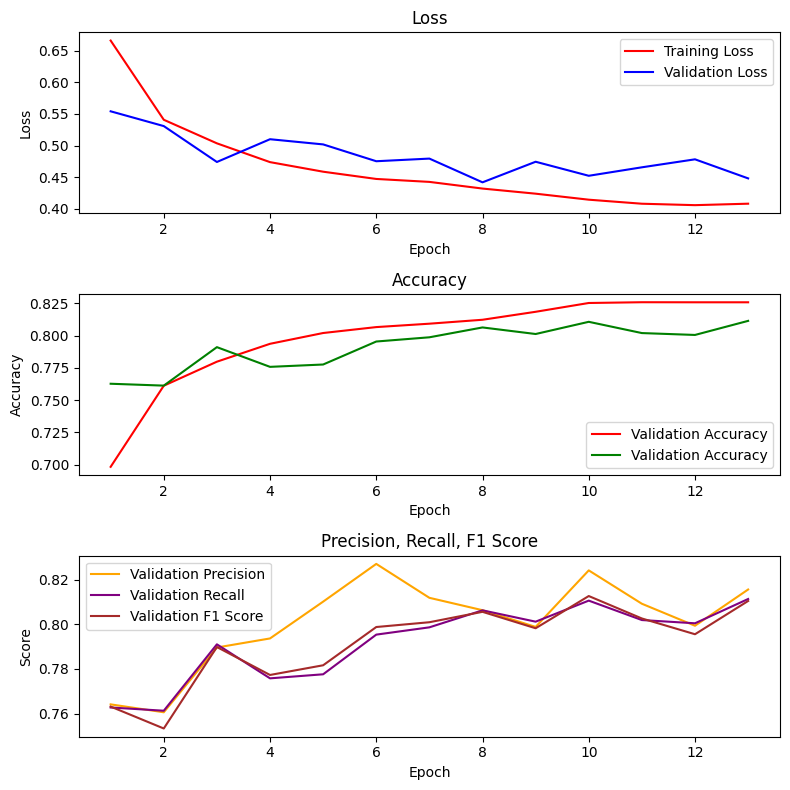

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(results):
    num_epochs = len(results['epoch_loss'])
    epochs = range(1, num_epochs + 1)

    # Loss 그래프
    fig, axes = plt.subplots(3, 1, figsize=(8, 8))

    axes[0].plot(epochs, results['epoch_loss'], label='Training Loss', color='red')
    axes[0].plot(epochs, results['val_loss'], label='Validation Loss', color='blue')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Accuracy 그래프
    axes[1].plot(epochs, results['train_accuracy'], label='Validation Accuracy', color='red')
    axes[1].plot(epochs, results['val_accuracy'], label='Validation Accuracy', color='green')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Precision, Recall, F1 Score 그래프
    axes[2].plot(epochs, results['val_precision'], label='Validation Precision', color='orange')
    axes[2].plot(epochs, results['val_recall'], label='Validation Recall', color='purple')
    axes[2].plot(epochs, results['val_f1'], label='Validation F1 Score', color='brown')
    axes[2].set_title('Precision, Recall, F1 Score')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Score')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# 학습 결과 시각화
plot_training_history(results)


# ***7. model test***

In [ ]:
# timm 라이브러리를 사용하여 ViT 모델 불러오기
model_name = 'vit_base_patch16_224'
model = timm.create_model(model_name, pretrained=True)

dropout_prob = 0.5
in_features = model.head.in_features

# 새로운 분류 레이어 정의
num_classes = 4  # 새로운 클래스 수
classifier = nn.Sequential(
    nn.Dropout(dropout_prob),
    nn.Linear(in_features, num_classes)
)
model.head = classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 저장된 모델 가중치 로드
state_dict = torch.load('best_model.pth', map_location=device)  # GPU에서 가중치 로드
model.load_state_dict(state_dict)
model.eval()

# 테스트 데이터셋으로 평가
correct = 0
total = 0
predictions = []
targets = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # 입력 데이터를 GPU로 이동
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8126


# ***8. confusion matrix***

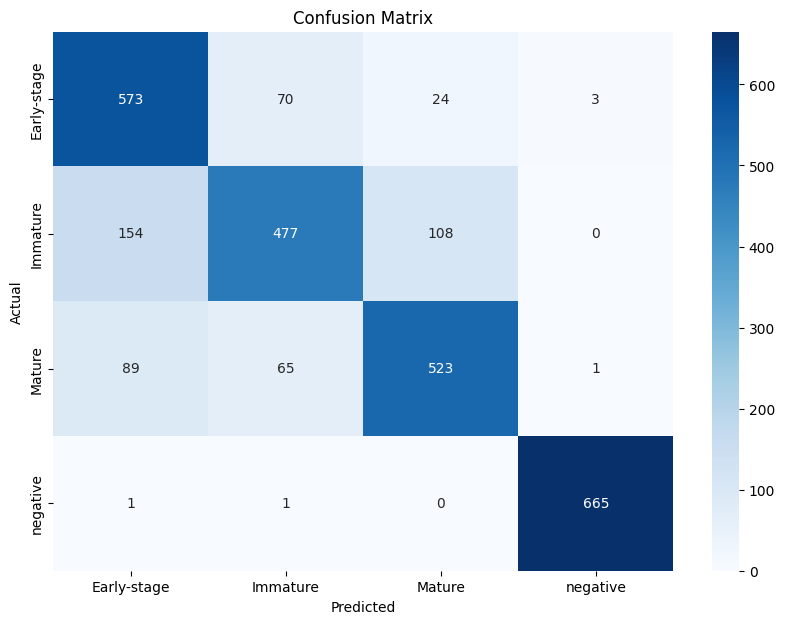

              precision    recall  f1-score   support

 Early-stage       0.70      0.86      0.77       670
    Immature       0.78      0.65      0.71       739
      Mature       0.80      0.77      0.78       678
    negative       0.99      1.00      1.00       667

    accuracy                           0.81      2754
   macro avg       0.82      0.82      0.81      2754
weighted avg       0.82      0.81      0.81      2754



In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 혼동 행렬 그리기
cm = confusion_matrix(targets, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 분류 리포트 출력
class_report = classification_report(targets, predictions, target_names=class_labels)
print(class_report)

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import utils

def visualize_batch(model, test_loader, device, class_labels):
    model.eval()
    model.to(device)  # 모델의 가중치를 GPU로 이동
    # 1배치 데이터 불러오기
    inputs, labels = next(iter(test_loader))
    inputs, labels = inputs.to(device), labels.to(device)

    # 모델 예측
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

    # 이미지 시각화
    fig, axes = plt.subplots(3, 5, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        img = utils.make_grid(inputs[i].cpu(), normalize=True).permute(1, 2, 0)
        ax.imshow(img)
        true_label = class_labels[labels[i].item()]
        pred_label = class_labels[predicted[i].item()]

        # 정답과 예측이 일치하는지 확인하고 글씨 색상 결정
        if true_label == pred_label:
            color = 'green'
        else:
            color = 'red'

        ax.set_title(f"True: {true_label}\nPredicted: {pred_label}", fontsize=9, color=color)
        ax.axis('off')

# 모델 예측 후의 1배치 이미지 시각화
visualize_batch(best_model, test_loader, device, class_labels)
